## 1. Load, show, and save images with OpenCV

### 1.1 Mount Google drive for dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir data
!cp -r drive/MyDrive/test/data .
!mkdir data/train/pred
!mkdir data/val/pred
!mkdir data/test/pred

### 1.2 Instantiate plotting function

In [ ]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

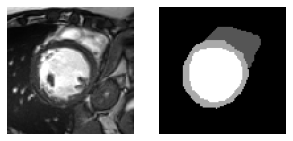

True

In [ ]:
import os
import cv2 #import OpenCV

data_dir = './data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

### 1.3 Instantiate function to split mask image to four channels

In [ ]:
import numpy as np


def mask_split(masks, batch):
    masks = masks.numpy()
    res = np.zeros((batch, 4, 96, 96))
    for idx, mask in enumerate(masks):
        for row_idx, rows in enumerate(mask):
            for col_idx, val in enumerate(rows):
                val = int(val)
                if val <= 3:
                    res[idx][val][row_idx][col_idx] = 1
    return torch.tensor(res)

## 2. Define a segmentation model

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [ ]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


The current device is cuda:0


### 2.2 Define a Segmentation Model

The following are the three models were defined, where all these models are popular choices for semantic segmentation.  

**1- FCN:**

The suggested FCN architecture is taught end-to-end in a single learning stage on a graphics processing unit (GPU) to perform inference at each pixel, a job known as pixel-wise labelling or per-pixel categorization. The model segments each image independently in milliseconds during testing, allowing it to be run in parallel on clusters of GPUs, or both for scalable and accurate ventricular segmentation.

In short-axis cardiac MRI recorded at various sites and from different scanners, the fully convolutional neural network (FCN) performs state-of-the-art semantic segmentation. The FCN architecture comprises 15 stacked convolution
layers and three layers of overlapping, two-pixel strided max pooling. Each convolution layer is followed by Rectified Linear Unit (ReLU) activation function and MVN operation.


Each short-axis slice shows the heart cavity, which contains both the left and right ventricles, about in the centre. To determine our region of interest, we use the square centre crop of each image (ROI). The FCN model's accuracy performance can be influenced by the size of the ROI. To crop the ROI at several sizes that completely contain the ventricles, we used a multi-resolution technique. We normalise each input image's pixel intensity distribution by removing its mean and dividing the difference by the standard deviation. The normalised output is a picture with zero mean and unit variance pixel values. In order to reduce overfitting and increase model generalisation, we use affine transformations (rotation, vertical flipping, and horizontal flipping) to enrich the training set.

**2- Deeplab**

A deep convolutional neural network ResNet-101 performs semantic segmentation by two steps. First, converting all fully connected layers to convolutional layers (i.e., fully convolutional network). Second, increasing feature resolution with atrous convolutional layers, allowing us to compute feature responses every 8 pixels rather than every 32 pixels in the original network. In the implementation, bi-linear interpolation is used to upsample the score map by a factor of eight to reach the original picture resolution, which is subsequently fed into a fully connected CRF that refines the segmentation findings.

The use of DCNNs for semantic segmentation or other dense prediction tasks has been demonstrated to be simple and effective in using fully convolutional DCNNs. The recurrent use of max-pooling and striding at successive layers of these networks diminishes the spatial resolution of the resulting feature maps by a factor of 32 in each direction in modern DCNNs. The use of 'deconvolutional' layers offers a partial solution, although it necessitates additional memory and time.  Instead, atrous convolution is used, where it  was originally created for computing the undecimated wavelet transform efficiently in the "algorithme à trous". 

We may compute the responses of any layer at any desired resolution using this approach. 
It can be used after a network has been trained, but it can also be easily integrated into the training process. To double the spatial density of computed feature responses in ResNet-101 networks, The last pooling or convolutional layer is located to reduces resolution ('pool5' or 'conv5 1', respectively), stride is setted to 1 to avoid signal decimation, and all subsequent convolutional layers are replaced with atrous convolutional layers with rate r = 2. In order to keep both computation and parameter count under control, state-of-the-art DCNNs use spatially tiny convolution kernels (usually 3*3). Atrous convolution with rate r introduces (r-1) zeros between successive filter values, effectively widening the kernel size of a (k*k) filter to ke = k + (k -1)(r -1) while reducing the number of parameters and computation. As a result, it provides an effective mechanism for controlling the field of view and determining the ideal balance between accurate localization (narrow field of view) and context assimilation (large field-of-view). The input feature map is subsampled by a factor equal to the atrous convolution rate r, then deinterlace it to produce r2 that reduces resolution maps, one for each of the rr possible shifts. Following that, ordinary convolution is used to these intermediate feature maps, and they are re-interlaced to the original image resolution. It allows us to employ off-the-shelf highly efficient convolution methods by reducing atrous convolution to conventional convolution.

**3- Unet:**

U-net architecture is based on the fully convolutional network where it was developed for biomedical image segmentation. Recent studies showed that U-net architecture is widely used in medical image segmentation. The reason behind that is that these images are usually expensive and difficult to collect , where this architecture has the feature to train the model with a small dataset by using these samples efficiently .
This architecture  (illustrated in Figure 1) consists of two paths, namely  contracting path and expansive path. In the first path, the input passes through repetitive application of two 3x3 convolutions. For downsampling each application is followed by a rectified linear unit (ReLU) and max pooling (2x2) and the number of channels is doubled. In the expansive path, the operations are the opposite where each step involves upsampling of the feature map and then applying up-convolution (2x2) that updates the number of channels  to the halve. After that, it is combined with a corresponding feature map in the contracting path, which needs to be cropped to match the image size in the expansive path. Then, passed through two 3x3 convolutions and followed by ReLU for each convolution. Last layer (1x1 convolution) is mapped to each 64  feature vector to the number of classes where in our case is 4 classes.
Our implementation followed the same proposed architecture  in [1] except the number of classes where it was two and here is changed to 4 classes (background, LV, RV, Myo). Also, our model is padded convolutions due to the constraints to have the same image size of the input where in [1] they used unpadded convolutions. Moreover, choosing the loss function: cross entropy loss , and the optimizer:stochastic gradient descent was based on the recommendation from the same paper.
 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF


"""
Model: Modified FCN
Paper: ...
Source: ...
"""
def crop_tensors(tensors):
    h_dims, w_dims = [], []
    for t in tensors:
        t_shape = list(t.shape)
        h_dims.append(t_shape[2])
        w_dims.append(t_shape[3])
    crop_h, crop_w = (h_dims[1] - h_dims[0]), (w_dims[1] - w_dims[0])
    rem_h = crop_h % 2
    rem_w = crop_w % 2
    crop_h_dims = (crop_h // 2, crop_h // 2 + rem_h)
    crop_w_dims = (crop_w // 2, crop_w // 2 + rem_w)
    if crop_h_dims == (0, 0) or crop_w_dims == (0, 0):
      return tensors[1]
    
    tmp = tensors[1].clone().cpu().detach().numpy()
    tmp = tmp[:, :, crop_h_dims[0]:-crop_h_dims[1], crop_w_dims[0]:-crop_w_dims[1]]
    cropped = torch.tensor(tmp)
    global device
    cropped = cropped.to(device)
    
    return cropped
    # return tensors[1]


class ModFCN(nn.Module):
    def __init__(self):
        super(ModFCN, self).__init__()
        self.conv_init = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.conv2_3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.conv3_4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding='same')
        self.conv4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool2d(3, stride=2)

        self.deconv = nn.Conv2d(in_channels=512, out_channels=4, kernel_size=1, stride=1)
        self.upsamp = nn.ConvTranspose2d(in_channels=4, out_channels=4, kernel_size=3, stride=2)
        self.conv_to_four_256 = nn.Conv2d(in_channels=256, out_channels=4, kernel_size=1, stride=1)
        self.conv_to_four_128 = nn.Conv2d(in_channels=128, out_channels=4, kernel_size=1, stride=1)
        self.conv_to_four_64 = nn.Conv2d(in_channels=64, out_channels=4, kernel_size=1, stride=1)

        self.softmax = nn.LogSoftmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        # self.conv_to_one = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=1, stride=1)
        self.resize = nn.Upsample(size=96)
        
    def forward(self, x):
        # Convolution
        x = F.relu(self.conv_init(x))
        for _ in range(2):
            x = F.relu(self.conv1(x))
        conv_iter1 = x.clone()
        x = self.pool(x)
        x = F.relu(self.conv1_2(x))
        for _ in range(3):
            x = F.relu(self.conv2(x))
        conv_iter2 = x.clone()
        x = self.pool(x)
        x = F.relu(self.conv2_3(x))
        for _ in range(3):
            x = F.relu(self.conv3(x))
        conv_iter3 = x.clone()
        x = self.pool(x)
        x = F.dropout(x)
        x = F.relu(self.conv3_4(x))
        for _ in range(3):
            x = F.relu(self.conv4(x))
        x = F.dropout(x)
        x = self.pool(x)

        # Deconv and Softmax
        x = self.deconv(x)

        x = self.upsamp(x)
        conv_iter3 = self.conv_to_four_256(conv_iter3)
        temp = crop_tensors([x.clone(), conv_iter3])
        x = torch.stack([x.clone(), temp]).mean(dim=0)

        x = self.upsamp(x)
        conv_iter2 = self.conv_to_four_128(conv_iter2)
        temp = crop_tensors([x.clone(), conv_iter2])
        x = torch.stack([x.clone(), temp]).mean(dim=0)

        x = self.upsamp(x)
        conv_iter1 = self.conv_to_four_64(conv_iter1)
        temp = crop_tensors([x.clone(), conv_iter1])
        x = torch.stack([x.clone(), temp]).mean(dim=0)

        x = self.softmax(x)
        # x = self.sigmoid(x)
        # x = self.conv_to_one(x)
        x = self.resize(x)

        return x



"""
Model: Prebuilt DeepLabv3_ResNet50
Paper: ...
Source: ...
"""
class DeepLab(nn.Module):
    def __init__(self):
        super(DeepLab, self).__init__()
        model = torchvision.models.segmentation.deeplabv3_resnet50(num_classes=4, aux_loss=False, pretrained=False)
        model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model = nn.ModuleList()
        self.model.append(model)
        self.out = lambda x: model(x)['out']
        
    def forward(self, x):
        y = self.out(x)

        return y



class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)




"""
Model: UNet Implementation
Paper: ...
Source: https://github.com/milesial/Pytorch-UNet
Adapted to be used in this assignment
"""
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNetNew(nn.Module):
    def __init__(self, n_classes=4, bilinear=True):
        super(UNetNew, self).__init__()
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.n_channels = 1

        self.inc = DoubleConv(self.n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if self.bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, self.bilinear)
        self.up2 = Up(512, 256 // factor, self.bilinear)
        self.up3 = Up(256, 128 // factor, self.bilinear)
        self.up4 = Up(128, 64, self.bilinear)
        self.outc = OutConv(64, self.n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = self.softmax(x)
        return x

### 2.3 Define a Loss function

In [ ]:
import torch.optim as optim

from torch.autograd import Variable

# Adapted from https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1, 1).squeeze(1).float()
        targets = targets.view(-1, 1).squeeze(1).float()

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')

        return BCE + dice_loss

## 3. Experiment: Tuning hyperparameter

### 3.1 Comparing the loss of 3 models (Modified FCN, U-Net, DeepLab)

Here we compare 3 models which are Modified FCN, Deeplab, and U-Net. We choose Cross Entropy for the loss function and Adam as optimizer. num_workers, epoch and batch size are initially set to 2,6 and 4 consecutively. From these settings, we want to look at how these models perform at computing train and validation loss.

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
torch.autograd.set_detect_anomaly(True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

[ModFCN 1-1] Train_loss 2.2490997314453125, Val_loss 2.415770244598389
[ModFCN 1-2] Train_loss 2.365121603012085, Val_loss 3.624043846130371
[ModFCN 1-3] Train_loss 3.285752058029175, Val_loss 145.47705688476563
[ModFCN 1-4] Train_loss 134.24948120117188, Val_loss 3.6081768035888673
[ModFCN 1-5] Train_loss 3.008918285369873, Val_loss 2.9340702056884767
[ModFCN 1-6] Train_loss 2.7750701904296875, Val_loss 2.4151472568511965
[ModFCN 1-7] Train_loss 2.4523494243621826, Val_loss 2.038005828857422
[ModFCN 1-8] Train_loss 1.9680705070495605, Val_loss 1.771137285232544
[ModFCN 1-9] Train_loss 1.659123420715332, Val_loss 1.6010177850723266
[ModFCN 1-10] Train_loss 1.5592846870422363, Val_loss 1.4861209392547607
[ModFCN 1-11] Train_loss 1.4576503038406372, Val_loss 1.4152940034866333
[ModFCN 1-12] Train_loss 1.394014835357666, Val_loss 1.369694423675537
[ModFCN 1-13] Train_loss 1.3637104034423828, Val_loss 1.332606554031372
[ModFCN 1-14] Train_loss 1.3393678665161133, Val_loss 1.304063558578491

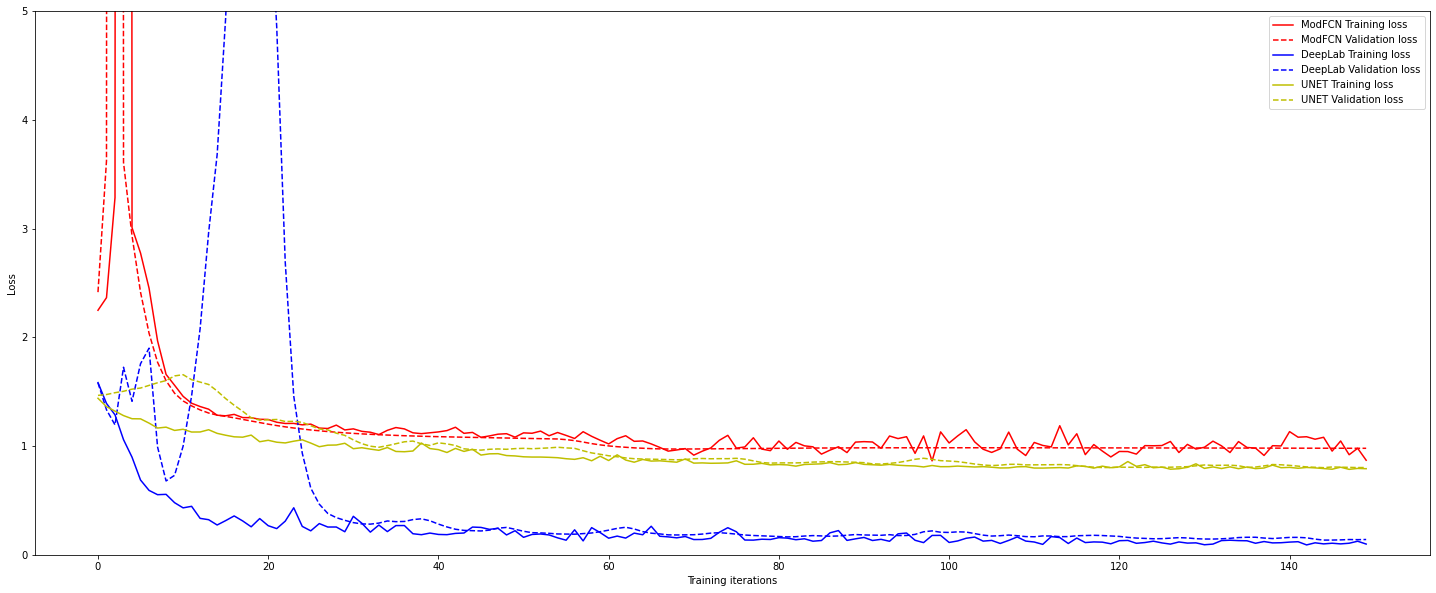

In [ ]:
# Experiment Part 1: Comparing the loss of 3 models (Modified FCN, U-Net, DeepLab)

models = {
    'ModFCN' : ModFCN().to(device),
    'DeepLab' : DeepLab().to(device),
    'UNET' : UNetNew().to(device)
}
losses, val_losses = {}, {}
num_workers, epoches, batch_size = 2, 6, 4

train_path = './data/train'
val_path = './data/val'
train_set = TrainDataset(train_path)
val_set = TrainDataset(val_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

for model in models:
    curr_model = models[model]
    losses[model] = list()
    val_losses[model] = list()
    Loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(curr_model.parameters())

    for epoch in range(epoches):
        running_loss = 0.0

        for iteration, sample1 in enumerate(training_data_loader):
            img_train, mask_train = sample1
            img_train, mask_train = img_train.to(device).unsqueeze(1), mask_train.long().to(device)

            curr_model.train()
            optimizer.zero_grad()
            outputs_train = curr_model(img_train)
            loss = Loss(outputs_train, mask_train)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            with torch.no_grad():
                running_val_loss = 0.0
                curr_model.eval()

                for sample2 in validation_data_loader:
                    img_val, mask_val = sample2
                    img_val, mask_val = img_val.to(device).unsqueeze(1), mask_val.long().to(device)
                    
                    outputs_val = curr_model(img_val)
                    val_loss = Loss(outputs_val, mask_val)
                    running_val_loss += val_loss.item()

            losses[model].append(running_loss)
            val_losses[model].append(running_val_loss/5)
            
            print(f"[{model} {epoch+1}-{iteration+1}] Train_loss {running_loss}, Val_loss {running_val_loss/5}")

            running_loss = 0.0
            running_val_loss = 0.0

plt.figure(figsize=(25,10))
plt.plot(range(len(losses['ModFCN'])), losses['ModFCN'],'r', label="ModFCN Training loss")
plt.plot(range(len(val_losses['ModFCN'])), val_losses['ModFCN'],'r--', label="ModFCN Validation loss")

plt.plot(range(len(losses['DeepLab'])), losses['DeepLab'],'b', label="DeepLab Training loss")
plt.plot(range(len(val_losses['DeepLab'])), val_losses['DeepLab'],'b--', label="DeepLab Validation loss")
plt.plot(range(len(losses['UNET'])), losses['UNET'],'y', label="UNET Training loss")
plt.plot(range(len(val_losses['UNET'])), val_losses['UNET'],'y--', label="UNET Validation loss")
plt.ylim(0,5)
plt.xlabel("Training iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

From the graph above, we conclude that among these three models, FCN computed the highest loss. That way we discard FCN and take the other two models to next experiment.

### 3.2 Choosing the appropriate epoch and Loss function of the chosen model

From Section 3.1, we can see DeepLab_ResNet50 and UNet are more promising than others

#### 3.2.1 Finding epoch for DeepLab_ResNet50

##### 3.2.1.1 DeepLab_ResNet50 with CrossEntropyLoss

Model: DeepLab_Resnet50

Loss: CrossEntropyLoss

Optimizer: Adam

[Epoch 1] Train_Loss 0.4650471419095993, Val_Loss0.32639444172382354
[Epoch 2] Train_Loss 0.2387472176551819, Val_Loss0.23014848828315734
[Epoch 3] Train_Loss 0.19545343697071074, Val_Loss0.1959194004535675
[Epoch 4] Train_Loss 0.15735752403736114, Val_Loss0.1487342268228531
[Epoch 5] Train_Loss 0.12082239747047424, Val_Loss0.1340962290763855
[Epoch 6] Train_Loss 0.10681090503931046, Val_Loss0.1340393081307411
[Epoch 7] Train_Loss 0.09997429013252258, Val_Loss0.14661067724227905
[Epoch 8] Train_Loss 0.0915338459610939, Val_Loss0.11319875568151475
[Epoch 9] Train_Loss 0.08311743795871734, Val_Loss0.11823547035455703
[Epoch 10] Train_Loss 0.07636344447731971, Val_Loss0.12791990637779235


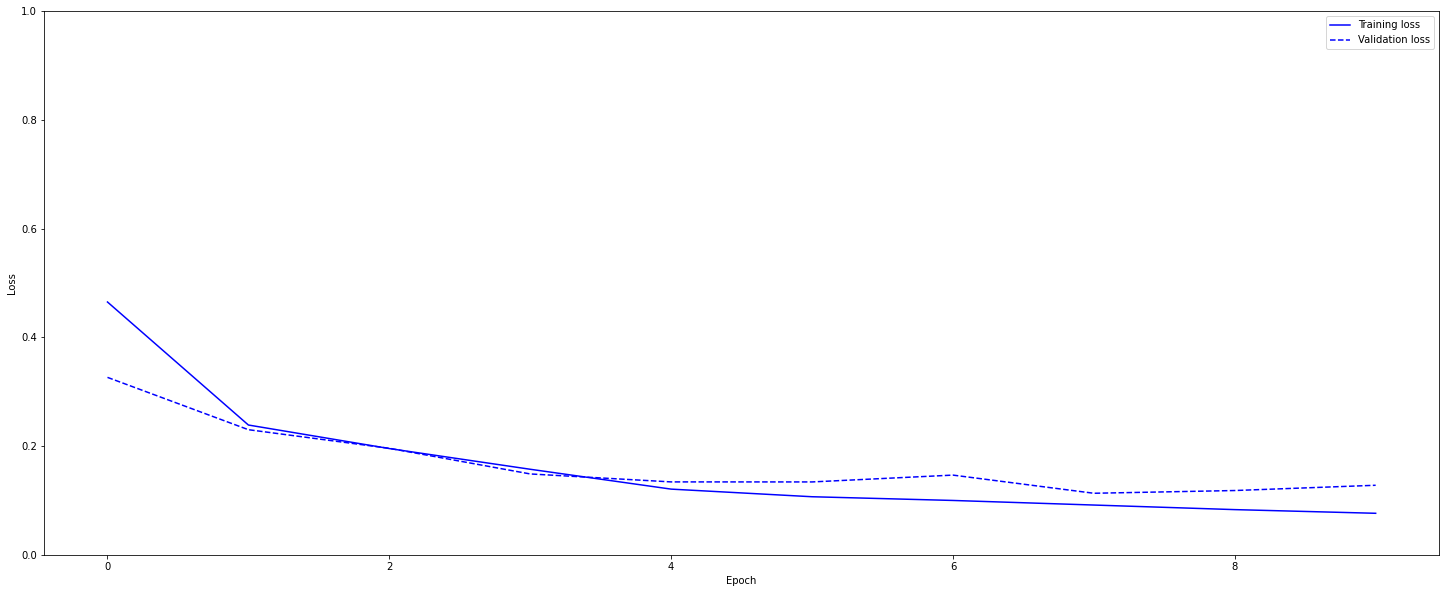

In [ ]:
# Experiment Part 2: Choosing the appropriate epoch of the chosen model

curr_model = DeepLab().to(device)
losses1 = list()
val_losses1 = list()
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(curr_model.parameters())

epoches = 10
for epoch in range(epoches):
    running_loss = 0.0
    curr_model.train()

    for iteration, sample1 in enumerate(training_data_loader):
        img_train, mask_train = sample1
        img_train, mask_train = img_train.to(device).unsqueeze(1), mask_train.long().to(device)

        optimizer.zero_grad()
        outputs_train = curr_model(img_train)
        loss = Loss(outputs_train, mask_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
    with torch.no_grad():
        running_val_loss = 0.0
        curr_model.eval()

        for sample2 in validation_data_loader:
            img_val, mask_val = sample2
            img_val, mask_val = img_val.to(device).unsqueeze(1), mask_val.long().to(device)
            
            outputs_val = curr_model(img_val)
            val_loss = Loss(outputs_val, mask_val)
            running_val_loss += val_loss.item()

    losses1.append(running_loss/25)
    val_losses1.append(running_val_loss/5)
      
    print(f"[Epoch {epoch+1}] Train_Loss {running_loss/25}, Val_Loss{running_val_loss/5}")

    running_loss = 0.0
    running_val_loss = 0.0

plt.figure(figsize=(25,10))
plt.plot(range(len(losses1)), losses1,'b', label="Training loss")
plt.plot(range(len(val_losses1)), val_losses1,'b--', label="Validation loss")
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Selected Epoch: 6

This epoch is chosen because from the data we can clearly see that after it passes the 6th epoch the validation data increases then it stablises at more or less 0.013, which around the same value for the 6th epoch. Under best circumstances this will be simply uneffecient since the added epoch does not bring any major improvment. on the other circumstances overfitting happens and the model actually decrease in accuracy after it passes the 6th epoch.

#### 3.2.2 Finding epoch for UNet

##### 3.2.2.1 UNet with CrossEntropyLoss

Model: UNet 

Loss: CrossEntropyLoss

Optimizer: Adam

[Epoch 1] Train_Loss 1.0707325720787049, Val_Loss1.3329071521759033
[Epoch 2] Train_Loss 0.8955217051506043, Val_Loss0.9111559748649597
[Epoch 3] Train_Loss 0.8322690796852111, Val_Loss0.8454147577285767
[Epoch 4] Train_Loss 0.8117023873329162, Val_Loss0.8271746635437012
[Epoch 5] Train_Loss 0.8008112716674805, Val_Loss0.8159842371940613
[Epoch 6] Train_Loss 0.7882499194145203, Val_Loss0.7936967968940735
[Epoch 7] Train_Loss 0.7875785970687866, Val_Loss0.8159372925758361
[Epoch 8] Train_Loss 0.7885458707809448, Val_Loss0.7950983285903931
[Epoch 9] Train_Loss 0.7817807292938233, Val_Loss0.7829354763031006
[Epoch 10] Train_Loss 0.7739992094039917, Val_Loss0.7746052026748658
[Epoch 11] Train_Loss 0.7715673804283142, Val_Loss0.7726900100708007
[Epoch 12] Train_Loss 0.7688778567314148, Val_Loss0.7702374339103699
[Epoch 13] Train_Loss 0.7687135505676269, Val_Loss0.7782639741897583
[Epoch 14] Train_Loss 0.7704976797103882, Val_Loss0.782388174533844
[Epoch 15] Train_Loss 0.7718742537498474, Va

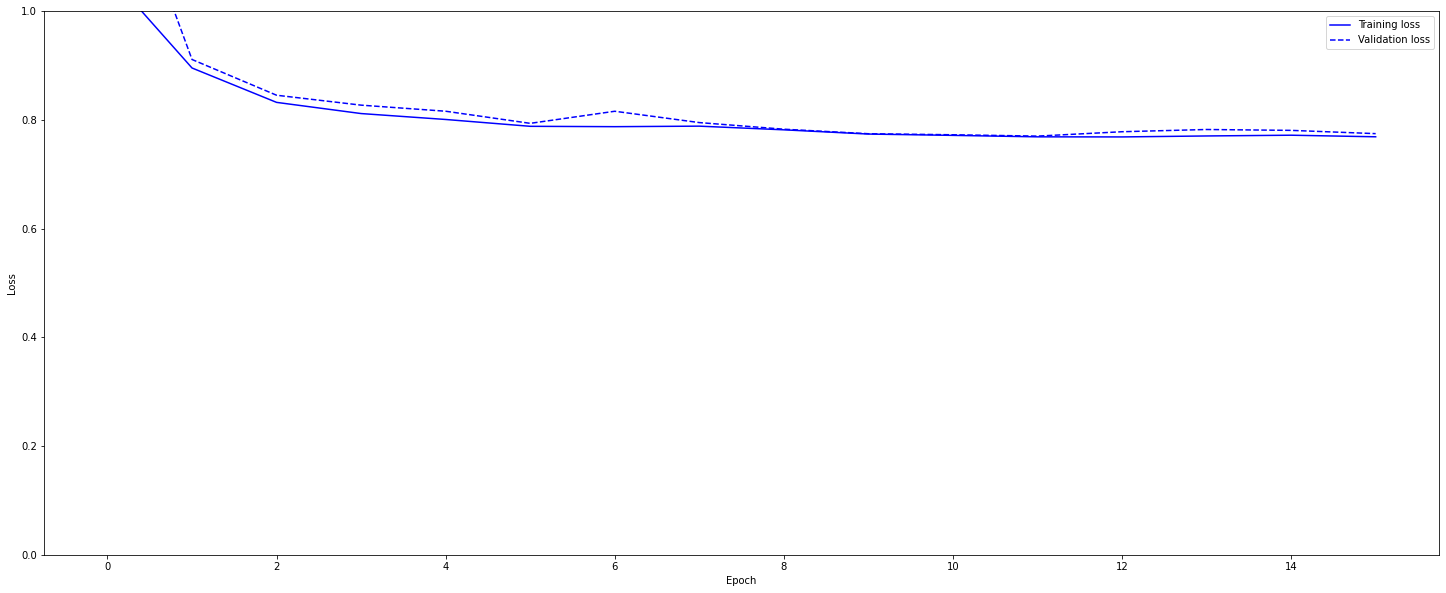

In [ ]:
# Experiment Part 2: Choosing the appropriate epoch of the chosen model

curr_model = UNetNew().to(device)
losses1 = list()
val_losses1 = list()
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(curr_model.parameters())

epoches = 16
for epoch in range(epoches):
    running_loss = 0.0
    curr_model.train()

    for iteration, sample1 in enumerate(training_data_loader):
        img_train, mask_train = sample1
        img_train, mask_train = img_train.to(device).unsqueeze(1), mask_train.long().to(device)

        optimizer.zero_grad()
        outputs_train = curr_model(img_train)
        loss = Loss(outputs_train, mask_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
    with torch.no_grad():
        running_val_loss = 0.0
        curr_model.eval()

        for sample2 in validation_data_loader:
            img_val, mask_val = sample2
            img_val, mask_val = img_val.to(device).unsqueeze(1), mask_val.long().to(device)
            
            outputs_val = curr_model(img_val)
            val_loss = Loss(outputs_val, mask_val)
            running_val_loss += val_loss.item()

    losses1.append(running_loss/25)
    val_losses1.append(running_val_loss/5)
      
    print(f"[Epoch {epoch+1}] Train_Loss {running_loss/25}, Val_Loss{running_val_loss/5}")

    running_loss = 0.0
    running_val_loss = 0.0

plt.figure(figsize=(25,10))
plt.plot(range(len(losses1)), losses1,'b', label="Training loss")
plt.plot(range(len(val_losses1)), val_losses1,'b--', label="Validation loss")
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Selected Epoch: 6.

Because from the data we can clearly see that after it passes the 6th epoch the validation data goes up then stright. Under best circumstances this will be simply uneffecient since the added epoch does not bring any major improvment. on the other circumstances overfitting happens and the model actually decrease in accuracy after it passes the 6th epoch. A notable feature of this model and loss function is its significantly worse than the other models in term of validation and training data. It is incredibly likely we wont be using this upon further evaluation.

##### 3.2.2.2 UNet with DiceBCELoss

Model: UNet

Loss: DiceBCELoss

Optimizer: Adam

[Epoch 1] Train_Loss 0.8517471337318421, Val_Loss4.10464391708374
[Epoch 2] Train_Loss 0.42718254804611205, Val_Loss1.1612524271011353
[Epoch 3] Train_Loss 0.23484206616878509, Val_Loss0.21479394733905793
[Epoch 4] Train_Loss 0.15623993396759034, Val_Loss0.20565805435180665
[Epoch 5] Train_Loss 0.13361641824245452, Val_Loss0.13601951599121093
[Epoch 6] Train_Loss 0.11927576422691345, Val_Loss0.11537348926067352
[Epoch 7] Train_Loss 0.08936974316835404, Val_Loss0.10897588431835174
[Epoch 8] Train_Loss 0.08627930760383606, Val_Loss0.09286389350891114
[Epoch 9] Train_Loss 0.09359937757253647, Val_Loss0.11441921144723892
[Epoch 10] Train_Loss 0.07991597518324851, Val_Loss0.08415056765079498
[Epoch 11] Train_Loss 0.08024417370557785, Val_Loss0.12893050462007521
[Epoch 12] Train_Loss 0.07572582691907882, Val_Loss0.11297607272863389
[Epoch 13] Train_Loss 0.06765405923128127, Val_Loss0.08683193773031235
[Epoch 14] Train_Loss 0.06539783582091331, Val_Loss0.08137679398059845
[Epoch 15] Train_Los

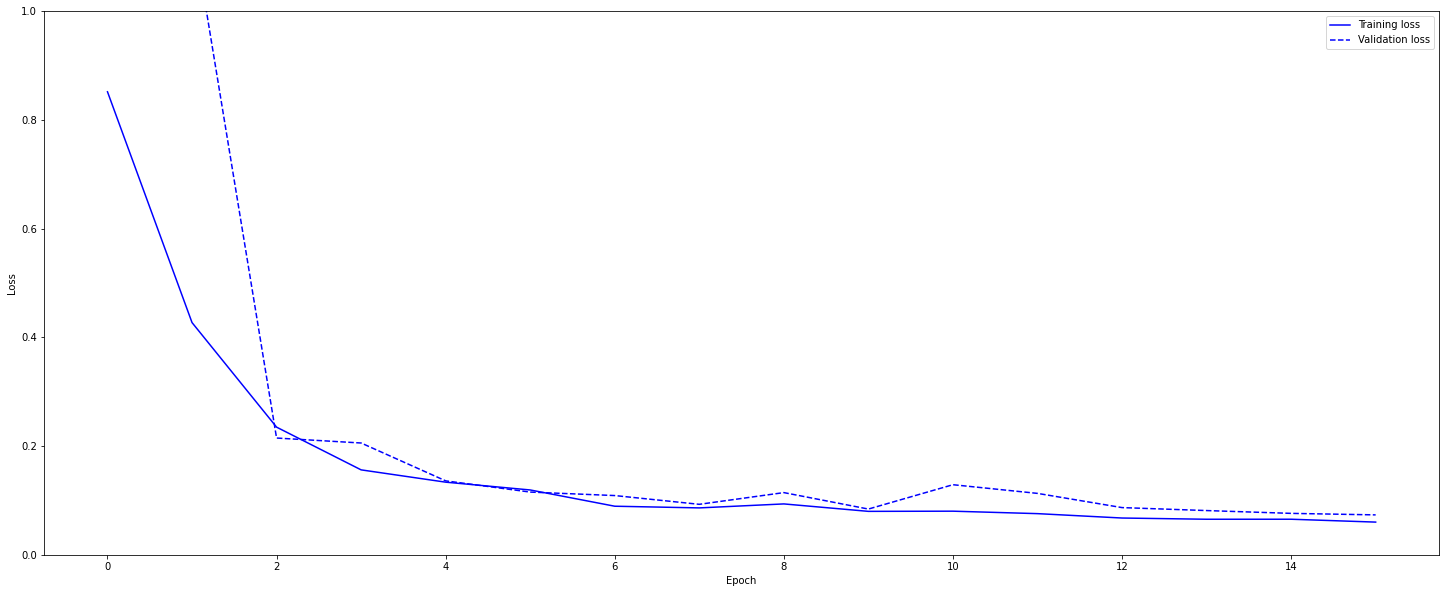

In [ ]:
# Experiment Part 2: Choosing the appropriate epoch of the chosen model

curr_model = UNetNew().to(device)
losses1 = list()
val_losses1 = list()
Loss = DiceBCELoss()
optimizer = optim.Adam(curr_model.parameters())

epoches = 16
for epoch in range(epoches):
    running_loss = 0.0
    curr_model.train()

    for iteration, sample1 in enumerate(training_data_loader):
        img_train, mask_train = sample1
        mask_train = mask_split(mask_train, batch_size)
        img_train, mask_train = img_train.to(device).unsqueeze(1), mask_train.long().to(device)

        optimizer.zero_grad()
        outputs_train = curr_model(img_train)
        loss = Loss(outputs_train, mask_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
    with torch.no_grad():
        running_val_loss = 0.0
        curr_model.eval()

        for sample2 in validation_data_loader:
            img_val, mask_val = sample2
            mask_val = mask_split(mask_val, batch_size)
            img_val, mask_val = img_val.to(device).unsqueeze(1), mask_val.long().to(device)
            
            outputs_val = curr_model(img_val)
            val_loss = Loss(outputs_val, mask_val)
            running_val_loss += val_loss.item()

    losses1.append(running_loss/25)
    val_losses1.append(running_val_loss/5)
      
    print(f"[Epoch {epoch+1}] Train_Loss {running_loss/25}, Val_Loss{running_val_loss/5}")

    running_loss = 0.0
    running_val_loss = 0.0

plt.figure(figsize=(25,10))
plt.plot(range(len(losses1)), losses1,'b', label="Training loss")
plt.plot(range(len(val_losses1)), val_losses1,'b--', label="Validation loss")
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Selected Loss: DiceBCELoss

For this part we are using DiceBCEloss as the loss function. We can clearly see its better. With 0.075 training and 0.11 validation loss for epoch 12. This extremly better than the previous loss function which gives us a 0.783 training loss and 0.793 validation loss.


Selected Epoch: 12

### 3.3 Choosing the appropriate optimizer for UNet + DiceBCELoss

For this part of the report we are going to choose the appropriate optimizer. the candidates are Adam, SGD and Adagrad.

Quick introduction on these three:

Adam(short for Adaptive Moment Estimation)is one of the most common optimizer. It works by computing the decaying averages of past and past squared gradients. 
Adam is generally considered fast and works well. But SGD tends to generalise better in deep learning.

Adagrad (shorts for Adaptive Gradient algorithm) works by keeping track of the sums of the gradient squared and then dapat the gradient in different directions.

And lastly SGD(stochastic gradient descent) is an iterative method for optimizing an objective function with suitable smoothness properties. It is considered to be regarded as a stochastic approximation of gradient descent optimization,because it replaces the real gradient by an estimatation . 
Its considered to be useful in high dimensional optimization problem since it has fast iteration.

The optimizer we will use will be picked based on the data we will get from this experiment. The method of reviewing said experiment remains the same, with training loss and validation loss.





[Optimizer Adam] Train_Loss 0.789133632183075, Val_Loss1.574729037284851
[Optimizer Adam] Train_Loss 0.39444995164871216, Val_Loss0.3477186322212219
[Optimizer Adam] Train_Loss 0.2342463767528534, Val_Loss0.28232755959033967
[Optimizer Adam] Train_Loss 0.16276115775108338, Val_Loss0.1782752752304077
[Optimizer Adam] Train_Loss 0.14646370381116866, Val_Loss0.15168020129203796
[Optimizer Adam] Train_Loss 0.12474629938602448, Val_Loss0.17750180810689925
[Optimizer Adam] Train_Loss 0.10572635352611542, Val_Loss0.14013204872608184
[Optimizer Adam] Train_Loss 0.09223487317562103, Val_Loss0.10949844717979432
[Optimizer Adam] Train_Loss 0.07996046334505082, Val_Loss0.08746309578418732
[Optimizer Adam] Train_Loss 0.08059726864099502, Val_Loss0.12418948709964753
[Optimizer Adam] Train_Loss 0.08277068585157395, Val_Loss0.11648865789175034
[Optimizer Adam] Train_Loss 0.0693378472328186, Val_Loss0.08199500888586045
[Optimizer SGD] Train_Loss 0.061481772661209105, Val_Loss0.07247912138700485
[Optimi

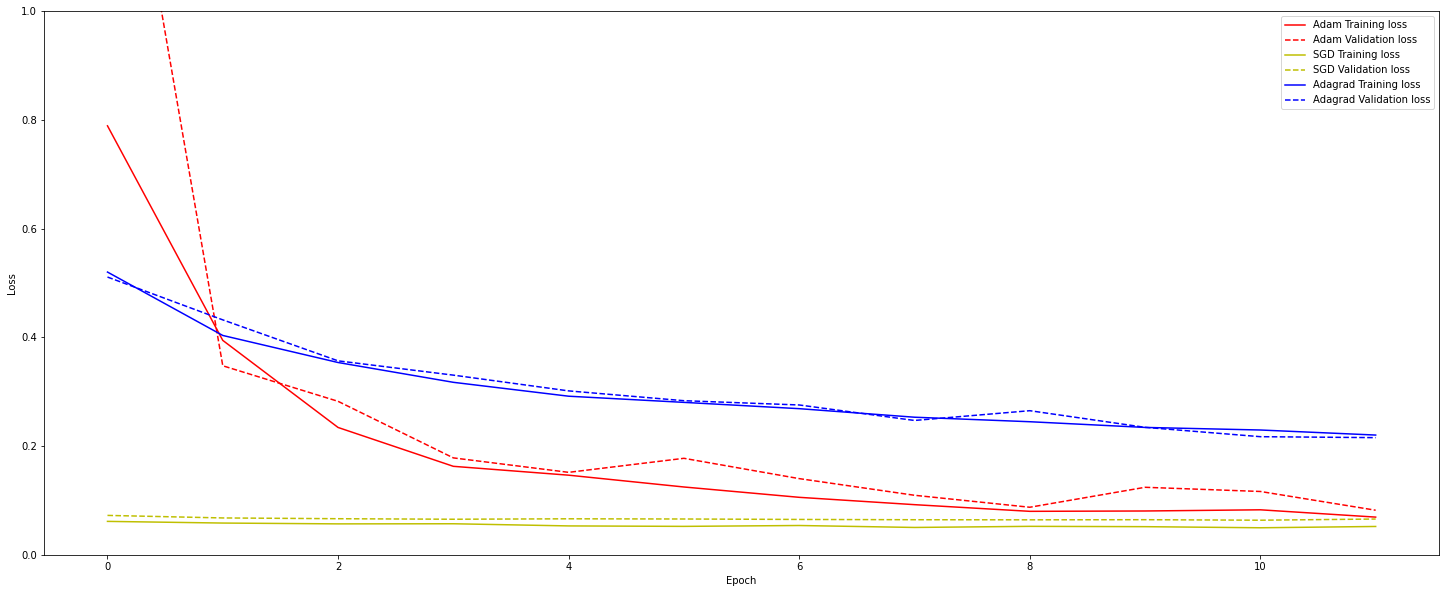

In [ ]:
# Experiment Part 3: Choosing the appropriate optimizer
curr_model = UNetNew().to(device)
Loss = DiceBCELoss()
epochs = 12

optimizers = [
    optim.Adam(curr_model.parameters()),
    optim.SGD(curr_model.parameters(), lr=0.01, momentum=0.9),
    optim.Adagrad(curr_model.parameters())
]
optimizer_losses = list()
for optimizer in optimizers:
    losses1 = list()
    val_losses1 = list()
    for epoch in range(epochs):
        running_loss = 0.0
        running_val_loss = 0.0
        curr_model.train()

        for iteration, sample1 in enumerate(training_data_loader):
            img_train, mask_train = sample1
            mask_train = mask_split(mask_train, batch_size)
            img_train, mask_train = img_train.to(device).unsqueeze(1), mask_train.long().to(device)

            optimizer.zero_grad()
            outputs_train = curr_model(img_train)
            loss = Loss(outputs_train, mask_train)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
          
        with torch.no_grad():
            curr_model.eval()

            for sample2 in validation_data_loader:
                img_val, mask_val = sample2
                mask_val = mask_split(mask_val, batch_size)
                img_val, mask_val = img_val.to(device).unsqueeze(1), mask_val.long().to(device)
                
                outputs_val = curr_model(img_val)
                val_loss = Loss(outputs_val, mask_val)
                running_val_loss += val_loss.item()

        losses1.append(running_loss/25)
        val_losses1.append(running_val_loss/5)
        print(f"[Optimizer {type(optimizer).__name__}] Train_Loss {running_loss/25}, Val_Loss{running_val_loss/5}")

    running_loss = 0.0
    running_val_loss = 0.0

    optimizer_losses.append((type(optimizer).__name__, losses1, val_losses1))

plt.figure(figsize=(25,10))
colors = 'ryb'
for idx, data in enumerate(optimizer_losses):
    plt.plot(range(len(data[1])), data[1], f'{colors[idx]}', label=f"{data[0]} Training loss")
    plt.plot(range(len(data[2])), data[2], f'{colors[idx]}--', label=f"{data[0]} Validation loss")
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Optimizer: SGD

We picked SGD because SGD gives much more impressive result with the minimum ammount of iteration and it consistently perform the best compared to the other optimizer in all of the epochs.

### 3.4 Choosing the batch size for UNet + DiceBCELoss

[Batch_size 4] Train_Loss 0.7580004155635833, Val_Loss18.212721061706542
[Batch_size 4] Train_Loss 0.36404773831367493, Val_Loss0.3082803964614868
[Batch_size 4] Train_Loss 0.22453807950019836, Val_Loss0.22152500450611115
[Batch_size 4] Train_Loss 0.16741150885820388, Val_Loss0.17636477649211885
[Batch_size 4] Train_Loss 0.15058424890041353, Val_Loss0.2113936275243759
[Batch_size 4] Train_Loss 0.11786366462707519, Val_Loss0.1365399956703186
[Batch_size 4] Train_Loss 0.10314581632614135, Val_Loss0.15090884566307067
[Batch_size 4] Train_Loss 0.09374523341655731, Val_Loss0.11536370515823365
[Batch_size 4] Train_Loss 0.08290551260113715, Val_Loss0.1351758822798729
[Batch_size 4] Train_Loss 0.07516811981797218, Val_Loss0.09612439125776291
[Batch_size 4] Train_Loss 0.08007784381508827, Val_Loss0.09696840345859528
[Batch_size 4] Train_Loss 0.07081805571913719, Val_Loss0.08142371624708175
[Batch_size 5] Train_Loss 0.05009794682264328, Val_Loss0.0718829169869423
[Batch_size 5] Train_Loss 0.0507

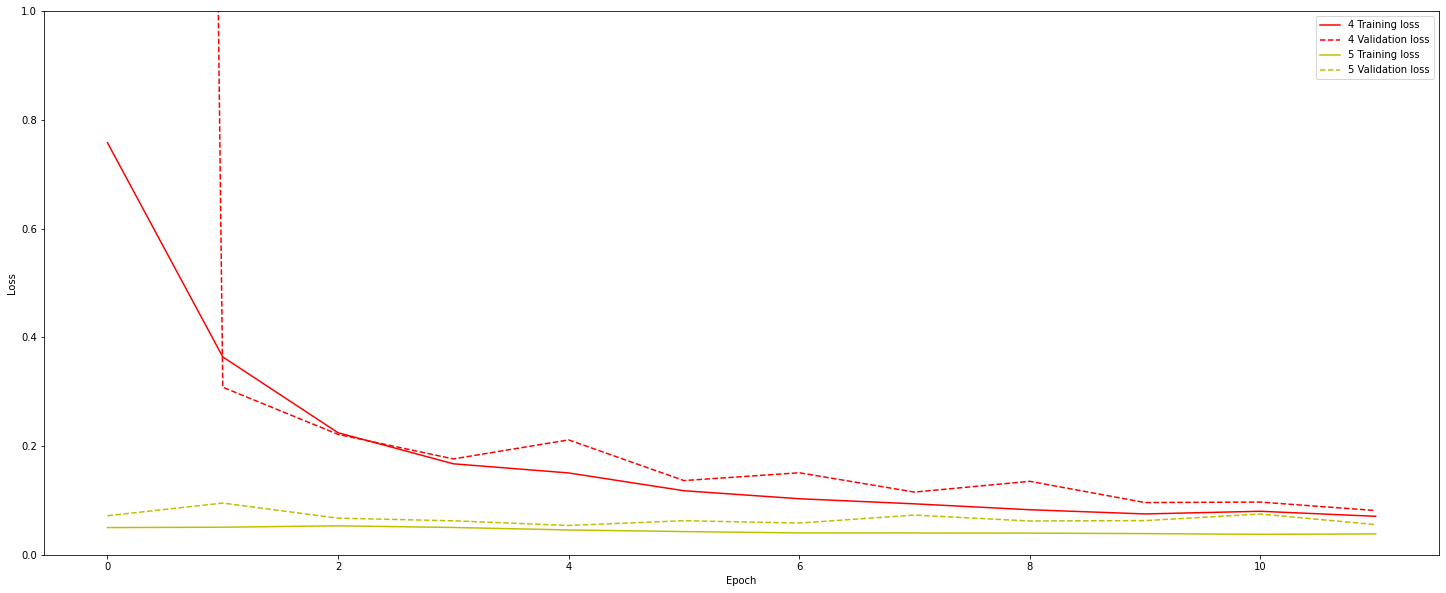

In [ ]:
# Experiment Part 4: Choosing the appropriate batch
curr_model = UNetNew().to(device)
Loss = DiceBCELoss()
optimizer = optim.Adam(curr_model.parameters())
epochs = 12

batch_sizes = [4, 5]
batch_losses = list()
for batch_size in batch_sizes:

    train_path = './data/train'
    val_path = './data/val'
    train_set = TrainDataset(train_path)
    val_set = TrainDataset(val_path)
    training_data_loader = DataLoader(dataset=train_set, num_workers=2, batch_size=batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=val_set, num_workers=2, batch_size=batch_size, shuffle=True)

    losses1 = list()
    val_losses1 = list()
    for epoch in range(epochs):
        running_loss = 0.0
        running_val_loss = 0.0
        curr_model.train()

        for iteration, sample1 in enumerate(training_data_loader):
            img_train, mask_train = sample1
            mask_train = mask_split(mask_train, batch_size)
            img_train, mask_train = img_train.to(device).unsqueeze(1), mask_train.long().to(device)

            optimizer.zero_grad()
            outputs_train = curr_model(img_train)
            loss = Loss(outputs_train, mask_train)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
          
        with torch.no_grad():
            curr_model.eval()

            for sample2 in validation_data_loader:
                img_val, mask_val = sample2
                mask_val = mask_split(mask_val, batch_size)
                img_val, mask_val = img_val.to(device).unsqueeze(1), mask_val.long().to(device)
                
                outputs_val = curr_model(img_val)
                val_loss = Loss(outputs_val, mask_val)
                running_val_loss += val_loss.item()

        losses1.append(running_loss/25)
        val_losses1.append(running_val_loss/5)
        print(f"[Batch_size {batch_size}] Train_Loss {running_loss/25}, Val_Loss{running_val_loss/5}")

    running_loss = 0.0
    running_val_loss = 0.0

    batch_losses.append((batch_size, losses1, val_losses1))

plt.figure(figsize=(25,10))
colors = 'ryb'
for idx, data in enumerate(batch_losses):
    plt.plot(range(len(data[1])), data[1], f'{colors[idx]}', label=f"{data[0]} Training loss")
    plt.plot(range(len(data[2])), data[2], f'{colors[idx]}--', label=f"{data[0]} Validation loss")
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Batch size: 5

By seeing the result, we can clearly state that batch = 5 in general has better performance than batch = 6, even when there's increasement in higher number of iterations it still manages to compute smaller loss compared to batch = 6. Thus we will be using batch size = 5 as well as DiceBCE as loss function and SGD as the optimizer that have been proven to be the most optimum to train the model and predict the data.

## 4. Train model and predict test data

### 4.1 Train network with the chosen model and epoch using both training and validation data

In [ ]:
# Result of Experiment: Train network with the chosen model and epoch using both training and validation data

curr_model = UNetNew().to(device)
Loss = DiceBCELoss()
optimizer = optim.SGD(curr_model.parameters(), lr=0.01, momentum=0.9)

train_path = './data/train'
val_path = './data/val'
train_set = TrainDataset(train_path)
val_set = TrainDataset(val_path)

num_workers, epoches, batch_size = 2, 12, 5
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

for epoch in range(epoches):
    for dataloader in [training_data_loader,validation_data_loader]:
        for sample in dataloader:
            img_train, mask_train = sample
            mask_train = mask_split(mask_train, batch_size)
            img_train, mask_train = img_train.to(device).unsqueeze(1), mask_train.long().to(device)

            optimizer.zero_grad()
            outputs_train = curr_model(img_train)
            loss = Loss(outputs_train, mask_train)
            loss.backward()
            optimizer.step()
    
    print(f'Processing epoch: {epoch+1}')

torch.save(curr_model.state_dict(), 'saved_model.pt')

Processing epoch: 1
Processing epoch: 2
Processing epoch: 3
Processing epoch: 4
Processing epoch: 5
Processing epoch: 6
Processing epoch: 7
Processing epoch: 8
Processing epoch: 9
Processing epoch: 10
Processing epoch: 11
Processing epoch: 12


### 4.2 Creating prediction from actual image

In [ ]:
data_paths = [
    './data/test',
    './data/train',
    './data/val'
]
num_workers = 4
batch_size = 5

for data_path in data_paths:
    test_set = TestDataset(data_path)
    test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

    model_fin = UNetNew().to(device)
    model_fin.load_state_dict(torch.load('./saved_model.pt'))
    model_fin.eval()

    for iteration, sample in enumerate(test_data_loader):
        start_idx = batch_size * iteration
        image_paths = test_set.img_files[start_idx:start_idx+batch_size]

        img = sample
        img = img.to(device).unsqueeze(1)
        pred = model_fin(img)

        # Move data to CPU
        img, pred = img.cpu().detach().numpy(), pred.cpu().detach().numpy()
        for i, prediction in enumerate(pred):
            # Set value to 1 if larger than threshold, else 0
            threshold = 0.5
            prediction = prediction.clip(min=threshold)
            for c in range(4):
                prediction[c,...][prediction[c,...] > threshold] = c
            
            # Merge the channel by getting the maximum of each channel
            pred_max = np.full((96, 96), 0, dtype=np.uint8)
            for mask in prediction:
                pred_max = np.maximum(pred_max, mask)

            # Visualize current image and prediction
            # show_image_mask(img[i].squeeze(), pred_max.squeeze())

            # Get current image path
            curr_img_path = image_paths[i].split('/')
            mask_path = curr_img_path
            mask_path[-2] = 'pred'

            # Append _mask to filename
            mask_filename = curr_img_path[-1].split('.')
            mask_filename = f"{mask_filename[0]}_mask.png"
            mask_path[-1] = mask_filename

            # Save current mask to folder
            mask_path = '/'.join(mask_path)
            print(f"Saving image: {mask_path}")
            cv2.imwrite(mask_path, pred_max.squeeze())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Saving image: ./data/test/pred/cmr145_mask.png
Saving image: ./data/test/pred/cmr140_mask.png
Saving image: ./data/test/pred/cmr191_mask.png
Saving image: ./data/test/pred/cmr180_mask.png
Saving image: ./data/test/pred/cmr139_mask.png
Saving image: ./data/test/pred/cmr194_mask.png
Saving image: ./data/test/pred/cmr175_mask.png
Saving image: ./data/test/pred/cmr190_mask.png
Saving image: ./data/test/pred/cmr152_mask.png
Saving image: ./data/test/pred/cmr184_mask.png
Saving image: ./data/test/pred/cmr171_mask.png
Saving image: ./data/test/pred/cmr123_mask.png
Saving image: ./data/test/pred/cmr177_mask.png
Saving image: ./data/test/pred/cmr132_mask.png
Saving image: ./data/test/pred/cmr166_mask.png
Saving image: ./data/test/pred/cmr144_mask.png
Saving image: ./data/test/pred/cmr167_mask.png
Saving image: ./data/test/pred/cmr174_mask.png
Saving image: ./data/test/pred/cmr133_mask.png
Saving image: ./data/test/pred/cmr199_mask.png
Saving image: ./data/test/pred/cmr147_mask.png
Saving image:

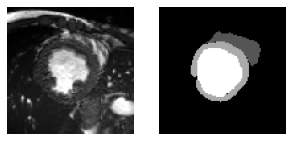

In [ ]:
data_dir = './data/test'
image = cv2.imread(os.path.join(data_dir,'image','cmr121.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'pred','cmr121_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)

## 5. Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 5.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    # mask1_pos = (mask1 == label_class).numpy().astype(np.float32)
    # mask2_pos = (mask2 == label_class).numpy().astype(np.float32)
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 5.2 Measure predicted masks of training set using dice score

In [ ]:
data_dir = './data/train'
actual_mask_files = glob(os.path.join(data_dir,'mask','*.png'))
pred_mask_files = glob(os.path.join(data_dir,'pred','*.png'))

sum_dice = 0.0
nan_dice = 0

for actual_mask_file in actual_mask_files:
    actual_mask_filename = actual_mask_file.split('/')[-1]
    pred_mask_file = glob(os.path.join(data_dir,'pred',actual_mask_filename))[0]

    actual_mask = cv2.imread((actual_mask_file), cv2.IMREAD_UNCHANGED)
    pred_mask = cv2.imread((pred_mask_file), cv2.IMREAD_UNCHANGED)

    running_dice = 0.0
    for c in range(1, 4):
        running_dice += categorical_dice(actual_mask, pred_mask, c)
    
    avg_dice = running_dice/3
    if np.isnan(avg_dice):
        nan_dice += 1
        continue
    sum_dice += avg_dice

print(f'\nAverage dice score: {sum_dice/(len(actual_mask_files)-nan_dice)}')


Average dice score: 0.8988709928185101
